In [279]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns

from collections import defaultdict
from itertools import combinations, permutations
from matplotlib import rcParams
from os import listdir
from os.path import join
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, ttest_ind, fisher_exact, hypergeom
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

plot_dir = 'intesParts_figures'
data_dir = 'intesParts_data'

In [280]:
# Load AGORA taxa
df = pd.read_csv(data_dir + '/agora_taxa.tsv', delimiter='\t')
df['species'] = [x[1] for x in df.organism.str.split(' ')]
agora_tax_df = df
agora_tax_df

,organism,seedid,kingdom,phylum,mclass,order,family,genus,oxygenstat,metabolism,...,reactions,metabolites,draftcreator,draftcreated,phenotype,imgid,ncbiid,platform,kbaseid,species
0,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva ATCC 49176 (592010.4),Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Facultative anaerobe,"Saccharolytic, fermentative or respiratory",...,2428,1250,Eugen Bauer,07/01/14,1.0,2.562617e+09,592010.0,ModelSEED,NaN,defectiva
1,Achromobacter xylosoxidans A8,Achromobacter xylosoxidans A8 (762376.5),Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1668,1229,NaN,NaN,NaN,NaN,762376.0,ModelSEED,kb_g_3268_model_gf,xylosoxidans
2,Achromobacter xylosoxidans NBRC 15126 = ATCC 2...,NaN,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1674,1216,NaN,NaN,NaN,NaN,1216976.0,Kbase,kb|g.208127,xylosoxidans
3,Acidaminococcus fermentans DSM 20731,Acidaminococcus fermentans DSM 20731 (591001.3),Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,Fermentative,...,1102,905,Laura Kutt,04/17/16,NaN,6.463119e+08,591001.0,Kbase,kb|g.2555,fermentans
4,Acidaminococcus intestini RyC-MR95,Acidaminococcus intestini RyC-MR95 (568816.4),Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,"Asaccharolytic, glutamate is fermented",...,1001,828,Eugen Bauer,08/03/14,4.0,2.511231e+09,568816.0,Kbase,NaN,intestini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,Yersinia frederiksenii ATCC 33641,Yersinia frederiksenii ATCC 33641 (349966.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Fermentative, respiratory",...,1743,1212,Laura Kutt,04/18/16,NaN,6.383412e+08,349966.0,Kbase,kb|g.1009,frederiksenii
814,Yersinia kristensenii ATCC 33638,Yersinia kristensenii ATCC 33638 (527012.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Aerobe,Respiratory,...,1710,1188,Laura Kutt,05/29/16,NaN,6.450588e+08,527012.0,Kbase,kb|g.2094,kristensenii
815,Yersinia pseudotuberculosis YPIII,Yersinia pseudotuberculosis YPIII (502800.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Saccharolytic, fermentative",...,1658,1184,Laura Kutt,04/18/16,NaN,6.415227e+08,502800.0,Kbase,kb|g.1842,pseudotuberculosis
816,Yersinia rohdei ATCC 43380,Yersinia rohdei ATCC 43380 (527004.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Obligate anaerobe,"Saccharolytic, fermentative",...,1705,1187,Laura Kutt,04/18/16,NaN,6.450588e+08,527004.0,Kbase,kb|g.2092,rohdei


In [281]:
# Load AGORA reactions and subsystems (needs to load all 818 models the first time)

subsys = defaultdict(set)

rxn_file = data_dir + '/agora_reactions.csv'
subsys_file = data_dir + '/agora_subsys.tsv'

try:
    rxn_df = pd.read_csv(rxn_file, index_col=0)
    
    with open(subsys_file, 'r') as f:
        for line in f:
            l = line.strip().split('\t')
            subsys[l[0]] = set(l[1:])
            
except FileNotFoundError:
    d = {}
    
    model_dir = 'models/AGORA-1.03-With-Mucins/sbml/'

    i = 0
    for x in listdir(model_dir):
        if x.endswith('.xml'):
            print(i, x)
            # Load model
            model = cobra.io.read_sbml_model(join(model_dir, x))
            
            # Get reactions
            d[model.id] = {r.id: 1 for r in model.reactions}
            
            # Get subsystems
            for g in model.groups:
                subsys[g.name] |= set(r.id for r in g.members)
            
            i += 1
                
    rxn_df = pd.DataFrame(d).fillna(0)
    
    # Save reactions
    rxn_df.to_csv(rxn_file)

    # Save subsystems
    with open(subsys_file, 'w') as f:
        for x in sorted(subsys):
            f.write(x + '\t')
            f.write('\t'.join(sorted(subsys[x])) + '\n')
                        
# Add mapping from reactions to subsystems
for x, s in dict(subsys).items():
    for r in s:
        subsys[r] = x
        
rxn_df = rxn_df[~rxn_df.index.str.contains('biomass')]
    
rxn_df, subsys

(           Abiotrophia_defectiva_ATCC_49176  Achromobacter_xylosoxidans_A8  \
 23DHMPO                                 1.0                            1.0   
 26DAPLLAT                               1.0                            0.0   
 2AHBUTI                                 1.0                            1.0   
 2MBCOATA                                1.0                            1.0   
 3HAD10M12                               1.0                            1.0   
 ...                                     ...                            ...   
 HICITD                                  0.0                            0.0   
 OXAG                                    0.0                            0.0   
 US7P1PT                                 0.0                            0.0   
 HYD5y                                   0.0                            0.0   
 THMDP                                   0.0                            0.0   
 
            Achromobacter_xylosoxidans_NBRC_15126 

In [282]:
agora_tax_df.nunique()

organism        818
seedid          649
kingdom           2
phylum           14
mclass           27
order            49
family           96
genus           227
oxygenstat       14
metabolism       76
gram              9
mtype             8
genes           527
reactions       590
metabolites     468
draftcreator      5
draftcreated     22
phenotype         5
imgid           633
ncbiid          816
platform          2
kbaseid         512
species         589
dtype: int64

['Actinobacteria', 'Bacteroidetes', 'Crenarchaeota', 'Cyanobacteria', 'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Planctomycetes', 'Proteobacteria', 'Spirochaetes', 'Synergistetes', 'Tenericutes', 'Thaumarchaeota', 'Verrucomicrobia']
['', 'Negative', 'Negative (inferred from sequence)', 'Negative due to the absence of a cell wall', 'Positive', 'Positive or negative', 'Structurally positive but may stain negative', 'Structurally positive but stains negative', 'Uncharacterized', 'Variable']
['', 'Aerobe', 'Aerobe, microaerophile', 'Aerotolerant', 'Anaerobe', 'Facultative anaerobe', 'Facultative anaerobe, air+CO2', 'Microaerophile', 'Microaerophile/ anaerobe', 'Microaerophilic', 'Nanaerobe', 'Obligate aerobe', 'Obligate anaerobe', 'Obligate anaerobe (inferred from sequence)', 'Obligatory anaerobe']
['', ' Saccharolytic, respiratory', 'Aaccharolytic, peptone and oligopeptides as main energy source', 'Asaccharolytic', 'Asaccharolytic, Fermentative', 'Asaccharolytic, fermentative', 'Asac

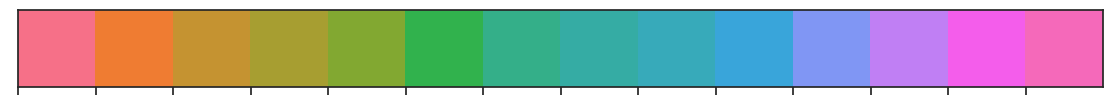

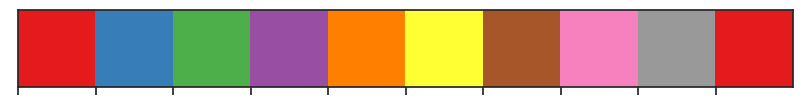

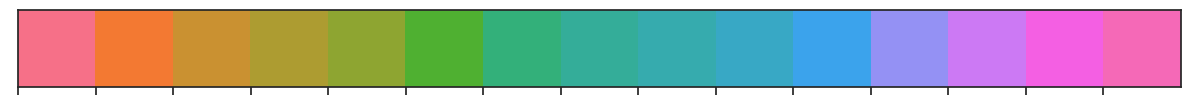

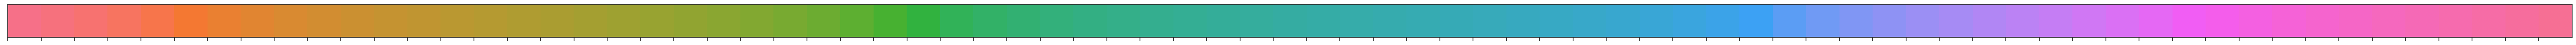

In [283]:
# Set microbe (column) colors
df = agora_tax_df.fillna('')
c = ['phylum', 'gram', 'oxygenstat', 'metabolism']
p = ['husl', 'Set1', 'husl', 'husl']
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
col_colors = [[palettes[i][df.loc[x, c[i]]] for x in df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

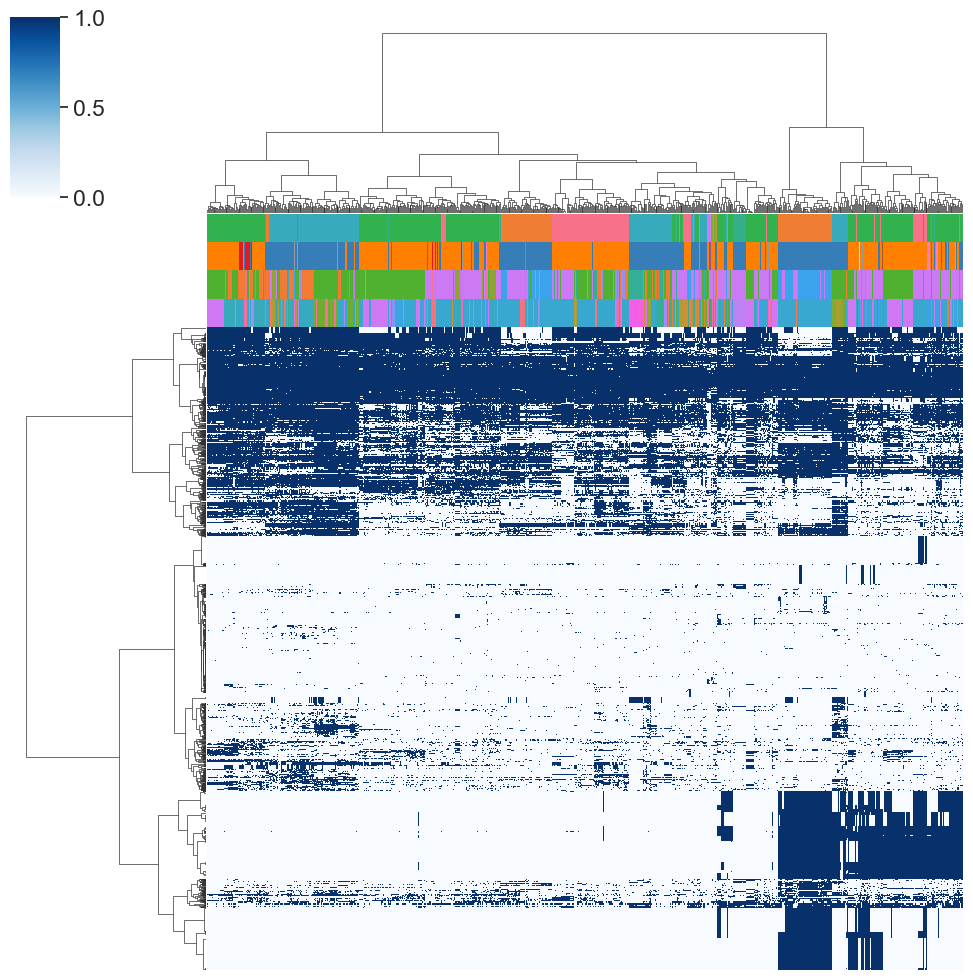

In [284]:
g = sns.clustermap(rxn_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, col_colors=col_colors)
g.savefig(join(plot_dir, 'clustermap_agora.png'), bbox_inches='tight')

In [285]:
# Choose suffix indicating whose data is used ("marwa" or "pabo")
suffix = 'marwa'

In [286]:
# Load sample data
df = pd.read_csv(data_dir + '/metadata_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
sample_df = df.loc[:, df.isna().sum() < 95]
sample_df

,sample.name,sample.no,sample_type,sample_region,phase,region,regime,region_regime,sample_regime
distal-MMV-T1-Rep1,3_1_1_D,187,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV
distal-MMV-T1-Rep2,3_1_2_D,180,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV
distal-MMV-T1-Rep3,3_1_3_D,246,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV
distal-MMV-T1-Rep4,3_1_4_D,146,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV
distal-MMV-T1-Rep5,3_1_5_D,99,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV
...,...,...,...,...,...,...,...,...,...
pyloric-VMV-T8-Rep1,3_8_1_P,222,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV
pyloric-VMV-T8-Rep2,3_8_2_P,172,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV
pyloric-VMV-T8-Rep3,3_8_3_P,123,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV
pyloric-VMV-T8-Rep4,3_8_4_P,101,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV


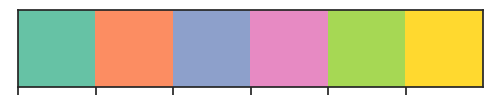

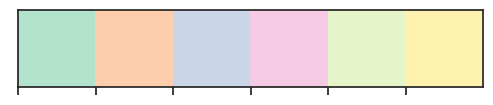

In [287]:
# Define region_regime order and palette
region_regime_order = {
    'marwa': ['pyloric.MMV', 'pyloric.VMV', 'middle.MMV', 'middle.VMV', 'distal.MMV', 'distal.VMV']
}
region_regime_palette = sns.color_palette('Set2', len(region_regime_order[suffix]))
region_regime_palette_pale = sns.color_palette('Pastel2', len(region_regime_order[suffix]))
sns.palplot(region_regime_palette)
sns.palplot(region_regime_palette_pale)

In [288]:
# Get digesta samples
gut = sample_df.sample_type == 'gut'
gut

distal-MMV-T1-Rep1     True
distal-MMV-T1-Rep2     True
distal-MMV-T1-Rep3     True
distal-MMV-T1-Rep4     True
distal-MMV-T1-Rep5     True
                       ... 
pyloric-VMV-T8-Rep1    True
pyloric-VMV-T8-Rep2    True
pyloric-VMV-T8-Rep3    True
pyloric-VMV-T8-Rep4    True
pyloric-VMV-T8-Rep5    True
Name: sample_type, Length: 93, dtype: bool

In [289]:
# Load taxonomy data
df = pd.read_csv(data_dir + '/tax_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
tax_df = df
tax_df

,kingdom,phylum,class,order,family,genus,species
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN
TGGGGAATCTTGCGCAATGGGCGAAAGCCTGACGCAGCAACGCCGCGTGCGGGATGAAGGCCTTCGGGTTGTAAACCGCTTTCAGCAGGGACGAAAATGACGGTACCTGCAGAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTCCGTAAGTCGAGTGTGAAAAATCTGGGCTCAACCCAGTGGAGCACTCGATACTGCGGTGACTAGAGTACGGTAGAGGAGTGTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCAACGGCGAAGGCAGCACTCTGGGCCGGTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACA,Bacteria,Actinobacteriota,Acidimicrobiia,Microtrichales,Microtrichaceae,NaN,NaN
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTAGGATCGTAAAACTCTGTTGTTGGAGAAGAACAGGGACTAGAGTAACTGTTAGTCCTTTGACGGTATCCAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATTAGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGTATGGGGAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,coryniformis
TGGGGAATTTTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGATTTAGAAGGCCTTCGGGTTGTAAAAATCTTTTGTATAGGAAGAAAATGACAGTACTATACGAATAAGGTCCGGCTAATTACGTGCCAGCAGCCGCGGTAATACGTAAGGACCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGTACGTAGGCGGGTCATTAAGTTAGAAGTCAAAGGCTATAGCTCAACTATAGTAAGCTTCTAAAACTGGCGACCTTGAGTAATGGAAGGGAAAGTGGAATTCCTAGTGTAGCGGTGGAATGCGCAGATATTAGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCCATTAACTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Anaerococcus,NaN,NaN
TTGGGAATCTTGGACAATGGGGGAAACCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGAAGATAATGACTGTACCGGGAGAATAAGCTCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTTTCCAAGTCAGTGGTTAAAGCCCAGAGCTCAACTCTGGAATTGCCATTGAAACTGGTGAACTTGAGTACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTTACTGACGCTCAGGCGCGACAGCGTGGGGATCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Micropepsales,Micropepsaceae,NaN,NaN
...,...,...,...,...,...,...,...
TGGGGAATCTTGCGCAATGAGCGAAAGCGTGACGCAGCAACGCCGCGTGGGGGAAGACGGCCTTCGGGTTGTAAACCCCTTTCAGGAGGGACGAAGGTTCACCGGTGAATAGCCGTGTGGATTGACGGTACCTCCAGAAGAAGCTCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGAGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGCGTAGGAGGCCTCATAAGTCCGTTGTGAAAGTCAAAGGCTCAACCTTTGAAAGCCGATGGATACTGTGAGGCTAGAGTCCGGAAGAGGCGAGTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCAATAGCGAAGGCAGCTCGCTGGGACGGTACTGACGCTAAGGCGCGAAAGCGTGGGGAGCGAACA,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,NaN
TCGAGAATCTTTCGCAATGGGGGCAACCCTGACGAAGCGACGCCGCGTGGAGGATGAAGGCCTTTGGGTTGTAAACTCCTGTCGGCTGGGACGAAATAGTTGCTGATTAATAATCAGCAGCCTTGACGGTACCAGCAAAGGAAGCCACGGCTAACTCTGTGCCAGCAGCCGCGGTAATACAGAGGTGGCAAGCGTTGTTCGGATTTATTGGGCGTAAAGGGTCCGTAGGCGGTTCGGAAAGTCAGATGTGAAATCCTACAGCTCAACTGTAGAACTGCATTTGAAACTTCCGGACTAGAGTATGAGAGGGGTTAAGGGAATTCCCGGTGTAAGGGTGAAATCTGCAGAGATCGGGAGGAACACCAGTCGCGAAGGCGCTTAACTGGCTCATTACTGACGCTCAGGGACGAAAGCTAGGGGAGCAAACG,Bacteria,Verrucomicrobiota,Omnitrophia,Omnitrophales,Omnitrophaceae,Candidatus Omnitrophus,NaN
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCAATACCGCGTGTGTGAAGAAGGCCTTAGGGTTGTAAAGCACTTTCAATTGGGAGGAATACCTATCGGTTAATACCCGATAGATTGACATTACCTTTAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGTTATTTAAGTCAGATGTGAAAGCCCCGGGCTCAACTTGGGAACGGCATTTGATACTGAGTAACTCGAGTTTGGGAGATGTAAGTGGAATTTCAGGTGTAGCGGTGAAATGCGTAGATATCTGAAGGAACACCAGTGGCGAAGGCGACTTACTGGCCTAAAACTGACGCTGAGGCACGAAAGCATGGGTAGCAAACA,Bacteria,Proteobact

In [290]:
# Load count data
df = pd.read_csv(data_dir + '/count_table_' + suffix + '.csv', index_col=0)
cnt_df = df
cnt_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TGGGGAATCTTGCGCAATGGGCGAAAGCCTGACGCAGCAACGCCGCGTGCGGGATGAAGGCCTTCGGGTTGTAAACCGCTTTCAGCAGGGACGAAAATGACGGTACCTGCAGAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTCCGTAAGTCGAGTGTGAAAAATCTGGGCTCAACCCAGTGGAGCACTCGATACTGCGGTGACTAGAGTACGGTAGAGGAGTGTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCAACGGCGAAGGCAGCACTCTGGGCCGGTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACA,TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTAGGATCGTAAAACTCTGTTGTTGGAGAAGAACAGGGACTAGAGTAACTGTTAGTCCTTTGACGGTATCCAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATTAGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGTATGGGGAGCGAACA,TGGGGAATTTTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGATTTAGAAGGCCTTCGGGTTGTAAAAATCTTTTGTATAGGAAGAAAATGACAGTACTATACGAATAAGGTCCGGCTAATTACGTGCCAGCAGCCGCGGTAATACGTAAGGACCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGTACGTAGGCGGGTCATTAAGTTAGAAGTCAAAGGCTATAGCTCAACTATAGTAAGCTTCTAAAACTGGCGACCTTGAGTAATGGAAGGGAAAGTGGAATTCCTAGTGTAGCGGTGGAATGCGCAGATATTAGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCCATTAACTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACA,TTGGGAATCTTGGACAATGGGGGAAACCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGAAGATAATGACTGTACCGGGAGAATAAGCTCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTTTCCAAGTCAGTGGTTAAAGCCCAGAGCTCAACTCTGGAATTGCCATTGAAACTGGTGAACTTGAGTACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTTACTGACGCTCAGGCGCGACAGCGTGGGGATCAAACA,TAGGGAATTTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGCAGGATGAAGGCCCTTGGGTCGTAAACTGCTTTTACGAGTGAAGATTATGACGGTAGCTCGTGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTCATACGGAGGATCCAAGCGTTATCCGGAATTACTGGGCGTAAAGAGTTGCGTAGGTGGCATTGTAAGTTGGTAGTGAAAGCGTTCGGCTCAACCGGATATCCATTACCAAAACTGCAAAGCTAGAGGATGAGAGAGGTTATTGGAATTCCCTGTGTAGGAGTGAAATCCGTAGATATAGGGAGGAACACCGATGGCGTAGGCAGATAACTGGCTCATTCCTGACACTAAGGCACGAAAGCGTGGGTAGCAAACG,TAAGGAATATTGGTCAATGGACGCAAGTCTGAACCAGCCATGCCGCGTGCAGGAAGACGGTCCTCTGGATTGTAAACTGCTTTTGTTAGGGAAGAAACCTTCGGATGCGTTCGAAGCTGACGGTACCTAAAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCGTTGTAAGTCAGTGGTGAAAGTTTGCAGCTTAACTGTAAAATTGCCATTGATACTGCAGTGCTTGAGTACAGATGAGGTGGGCGGAATGTGTCATGTAGCGGTGAAATGCATAGATATGACACAGAACACCGATTGCGAAGGCAGCTCACTAAACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGATCAAACA,TGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTTTCAGGGACGAATGTGCGATGTGTAAATAATGCATTGTAATGACGGTACCTGAGTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGTAATTATTGGGCGTAAAGCGCGCGCAGGTGGGATATTAAGTCTGGTGTTAAAGTTCGGGGCTCAACCCCGTGAAGCATTTGGAAACTGATATTCTTGAGTGCAGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGACTGTGTCTGACACTGAGGCGCGAAAGCCAGGGTAGTGAACG,TGAGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCGACGCCGCGTGCAGGATGAAGGCCTTCGGGTTGTAAACTGCTTTTATAAGTGAAGAATATGACGGTAACTTATGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTCATACGTAGGGTGCAAGCATTATCCGGAGTGACTGGGCGTAAAGAGTTGCGTAGGTGGTTTGTTAAGTGAATAGTGAAATCCGACGGCTCAACCGTACGGACTATTATTCAAACTGGCAGACTCGAGAATGGTAGAGGTAACTGGAATTTCTAGTGTAGGAGTGAAATCCGTAGATATTAGAAGGAACACCAATGGCGTAGGCAGGTTACTGGACCATTTCTGACACTGAGGCACGAAAGCGTGGGGAGCGAACC,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCAATGCCGCGTGTGTGAAGAAGGTCTTCGGATTGTAAAGCACTTTCGACGGGGACGATGATGACGGTACCCGTAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGTGTAGGCGGTTTGTACAGTCAGATGTGAAATCCCCGGGCTTAACCTGGGAGCTGCATTTGAGACGTGCAGACTAGAGTGTGAGAGAGGGTTGTGGAATTCCCAG

Text(0.5, 0, 'Abundance (log10)')

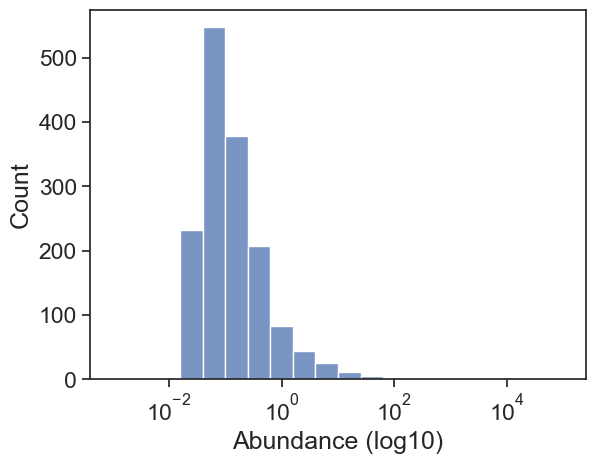

In [291]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(cnt_df.mean(), bins=20, binrange=(-3, 5), log_scale=True)
plt.xlabel('Abundance (log10)')

In [292]:
# Normalize counts to fraction
frac_df = cnt_df.T / cnt_df.sum(1)
frac_df = frac_df.T
frac_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TGGGGAATCTTGCGCAATGGGCGAAAGCCTGACGCAGCAACGCCGCGTGCGGGATGAAGGCCTTCGGGTTGTAAACCGCTTTCAGCAGGGACGAAAATGACGGTACCTGCAGAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTCCGTAAGTCGAGTGTGAAAAATCTGGGCTCAACCCAGTGGAGCACTCGATACTGCGGTGACTAGAGTACGGTAGAGGAGTGTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCAACGGCGAAGGCAGCACTCTGGGCCGGTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACA,TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTAGGATCGTAAAACTCTGTTGTTGGAGAAGAACAGGGACTAGAGTAACTGTTAGTCCTTTGACGGTATCCAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATTAGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGTATGGGGAGCGAACA,TGGGGAATTTTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGATTTAGAAGGCCTTCGGGTTGTAAAAATCTTTTGTATAGGAAGAAAATGACAGTACTATACGAATAAGGTCCGGCTAATTACGTGCCAGCAGCCGCGGTAATACGTAAGGACCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGTACGTAGGCGGGTCATTAAGTTAGAAGTCAAAGGCTATAGCTCAACTATAGTAAGCTTCTAAAACTGGCGACCTTGAGTAATGGAAGGGAAAGTGGAATTCCTAGTGTAGCGGTGGAATGCGCAGATATTAGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCCATTAACTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACA,TTGGGAATCTTGGACAATGGGGGAAACCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGAAGATAATGACTGTACCGGGAGAATAAGCTCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTTTCCAAGTCAGTGGTTAAAGCCCAGAGCTCAACTCTGGAATTGCCATTGAAACTGGTGAACTTGAGTACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTTACTGACGCTCAGGCGCGACAGCGTGGGGATCAAACA,TAGGGAATTTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGCAGGATGAAGGCCCTTGGGTCGTAAACTGCTTTTACGAGTGAAGATTATGACGGTAGCTCGTGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTCATACGGAGGATCCAAGCGTTATCCGGAATTACTGGGCGTAAAGAGTTGCGTAGGTGGCATTGTAAGTTGGTAGTGAAAGCGTTCGGCTCAACCGGATATCCATTACCAAAACTGCAAAGCTAGAGGATGAGAGAGGTTATTGGAATTCCCTGTGTAGGAGTGAAATCCGTAGATATAGGGAGGAACACCGATGGCGTAGGCAGATAACTGGCTCATTCCTGACACTAAGGCACGAAAGCGTGGGTAGCAAACG,TAAGGAATATTGGTCAATGGACGCAAGTCTGAACCAGCCATGCCGCGTGCAGGAAGACGGTCCTCTGGATTGTAAACTGCTTTTGTTAGGGAAGAAACCTTCGGATGCGTTCGAAGCTGACGGTACCTAAAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCGTTGTAAGTCAGTGGTGAAAGTTTGCAGCTTAACTGTAAAATTGCCATTGATACTGCAGTGCTTGAGTACAGATGAGGTGGGCGGAATGTGTCATGTAGCGGTGAAATGCATAGATATGACACAGAACACCGATTGCGAAGGCAGCTCACTAAACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGATCAAACA,TGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTTTCAGGGACGAATGTGCGATGTGTAAATAATGCATTGTAATGACGGTACCTGAGTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGTAATTATTGGGCGTAAAGCGCGCGCAGGTGGGATATTAAGTCTGGTGTTAAAGTTCGGGGCTCAACCCCGTGAAGCATTTGGAAACTGATATTCTTGAGTGCAGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGACTGTGTCTGACACTGAGGCGCGAAAGCCAGGGTAGTGAACG,TGAGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCGACGCCGCGTGCAGGATGAAGGCCTTCGGGTTGTAAACTGCTTTTATAAGTGAAGAATATGACGGTAACTTATGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTCATACGTAGGGTGCAAGCATTATCCGGAGTGACTGGGCGTAAAGAGTTGCGTAGGTGGTTTGTTAAGTGAATAGTGAAATCCGACGGCTCAACCGTACGGACTATTATTCAAACTGGCAGACTCGAGAATGGTAGAGGTAACTGGAATTTCTAGTGTAGGAGTGAAATCCGTAGATATTAGAAGGAACACCAATGGCGTAGGCAGGTTACTGGACCATTTCTGACACTGAGGCACGAAAGCGTGGGGAGCGAACC,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCAATGCCGCGTGTGTGAAGAAGGTCTTCGGATTGTAAAGCACTTTCGACGGGGACGATGATGACGGTACCCGTAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGTGTAGGCGGTTTGTACAGTCAGATGTGAAATCCCCGGGCTTAACCTGGGAGCTGCATTTGAGACGTGCAGACTAGAGTGTGAGAGAGGGTTGTGGAATTCCCAG

Text(0.5, 0, 'Fraction (log10)')

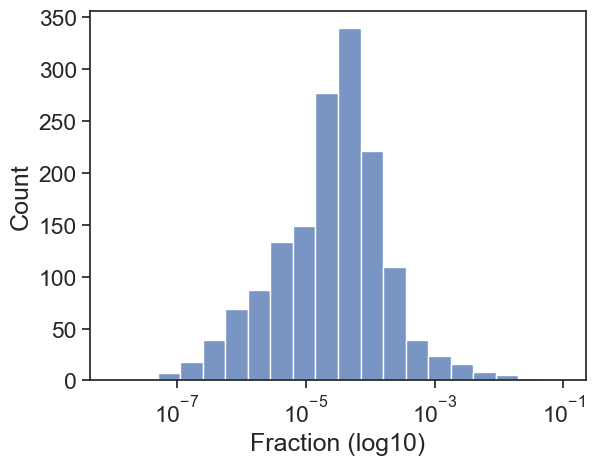

In [293]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(frac_df.mean(), bins=20, binrange=(-8, -1), log_scale=True)
plt.xlabel('Fraction (log10)')

Text(0, 0.5, 'Fraction (log10)')

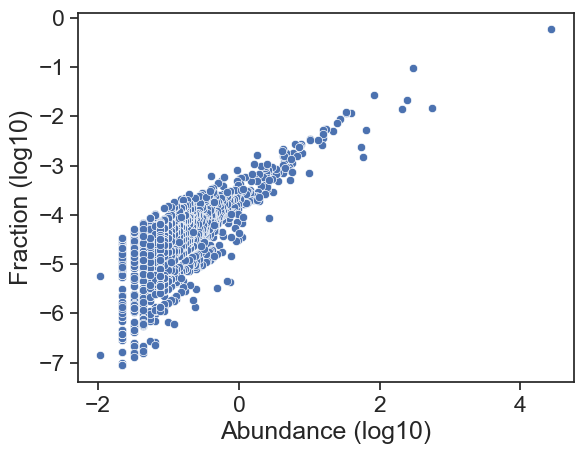

In [294]:
sns.set(style='ticks', font_scale=1.5)
sns.scatterplot(x=np.log10(cnt_df.mean()), y=np.log10(frac_df.mean()))
plt.xlabel('Abundance (log10)')
plt.ylabel('Fraction (log10)')

In [295]:
sample_df.nunique()

sample.name      93
sample.no        93
sample_type       1
sample_region     3
phase             1
region            3
regime            2
region_regime     6
sample_regime     2
dtype: int64

In [296]:
tax_df.nunique()

kingdom      1
phylum      22
class       43
order      112
family     223
genus      396
species    153
dtype: int64

In [297]:
# Choose sample variables and palettes
c = ['region_regime', 'phase']
p = ['husl', 'Blues']

['Acidobacteriota', 'Actinobacteriota', 'Armatimonadota', 'Bacteroidota', 'Bdellovibrionota', 'Campilobacterota', 'Chloroflexi', 'Deinococcota', 'Dependentiae', 'Desulfobacterota', 'Elusimicrobiota', 'Fibrobacterota', 'Firmicutes', 'Fusobacteriota', 'Gemmatimonadota', 'Myxococcota', 'Nitrospirota', 'Patescibacteria', 'Planctomycetota', 'Proteobacteria', 'Spirochaetota', 'Verrucomicrobiota']
['distal.MMV', 'distal.VMV', 'middle.MMV', 'middle.VMV', 'pyloric.MMV', 'pyloric.VMV']
['challenge']


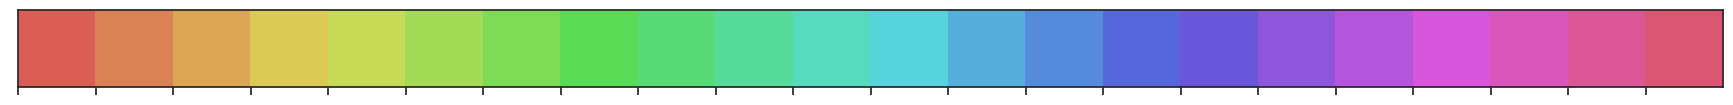

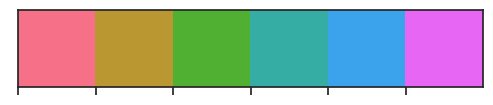

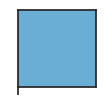

In [298]:
# Set microbe (column) colors
df = tax_df.fillna('')
rank = 'phylum'
palette = dict(zip(sorted(set(df[rank])), sns.color_palette('hls', len(set(df[rank])))))
col_colors = [palette[df.loc[x, rank]] for x in frac_df.columns]

sns.palplot(palette.values())
print(sorted(set(df[rank])))

# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

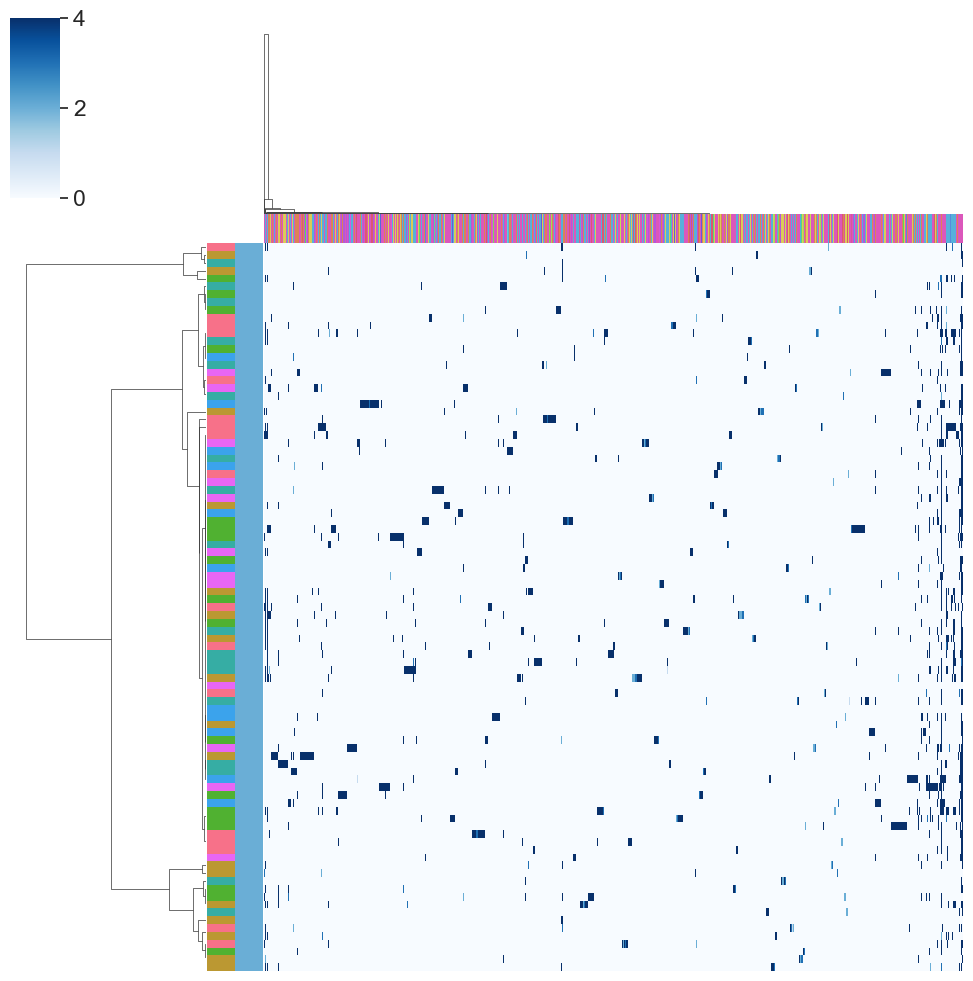

In [299]:
# Clustermap (counts)
g = sns.clustermap(cnt_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_cnt_' + suffix + '.png'), bbox_inches='tight')

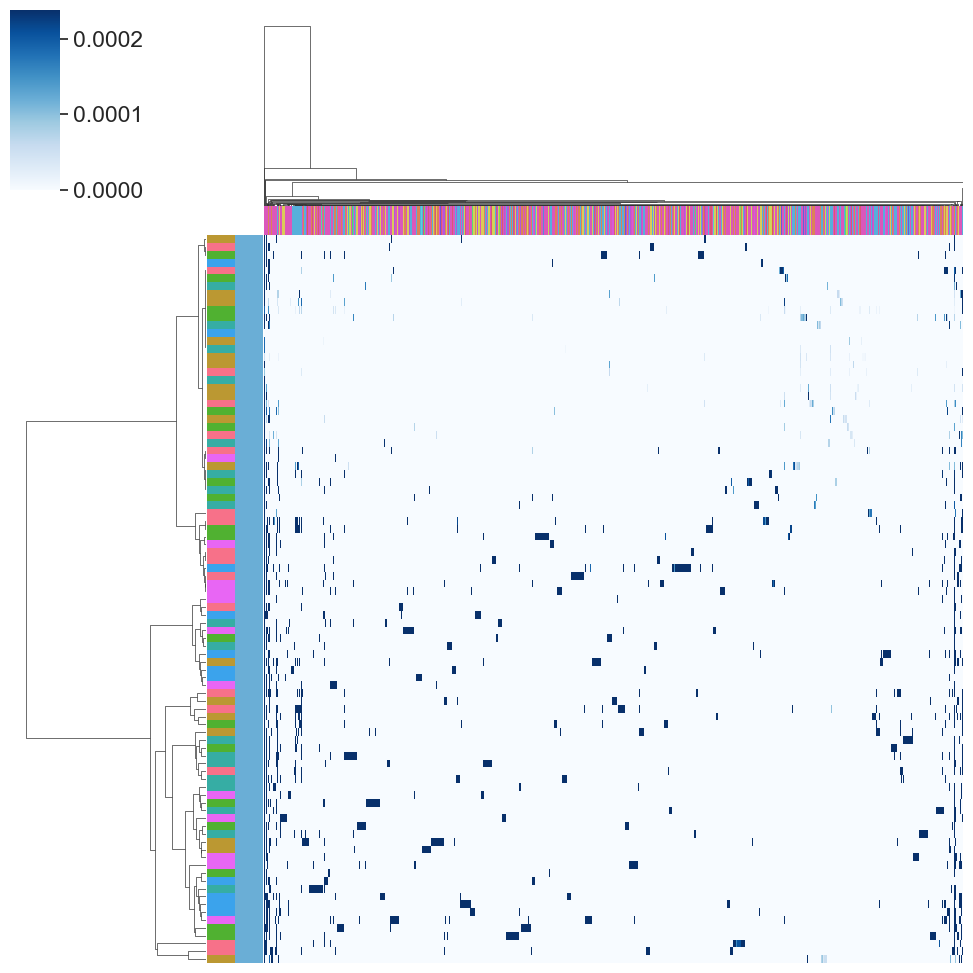

In [300]:
# Clustermap (fractions)
g = sns.clustermap(frac_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_frac_' + suffix + '.png'), bbox_inches='tight')

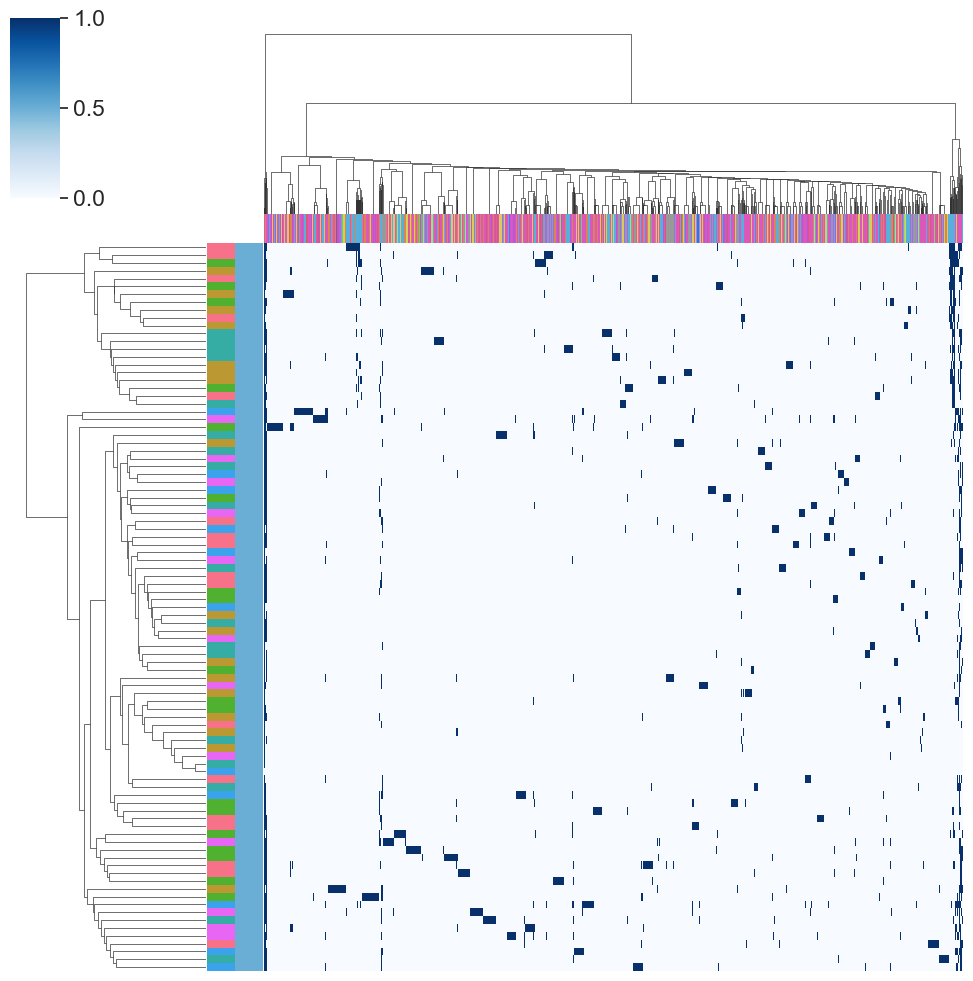

In [301]:
# Clustermap (binary)
g = sns.clustermap(frac_df > 0, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_bin_' + suffix + '.png'), bbox_inches='tight')

In [302]:
# PCA on counts
pca = PCA()
Z = StandardScaler().fit_transform(frac_df[gut])
T = pca.fit_transform(Z)
T.shape

(93, 93)

In [303]:
n = 5
sample_df.loc[gut, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,sample.name,sample.no,sample_type,sample_region,phase,region,regime,region_regime,sample_regime,pc1,pc2,pc3,pc4,pc5
distal-MMV-T1-Rep1,3_1_1_D,187,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-0.628910,-0.233036,-0.466353,-0.890846,-0.116332
distal-MMV-T1-Rep2,3_1_2_D,180,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-0.526470,-0.310427,-0.420308,-1.114624,-0.503083
distal-MMV-T1-Rep3,3_1_3_D,246,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-0.678854,-0.438368,-0.552197,-1.269564,-0.313505
distal-MMV-T1-Rep4,3_1_4_D,146,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-0.755071,-0.124028,-0.918297,-0.199738,0.309541
distal-MMV-T1-Rep5,3_1_5_D,99,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-0.724573,-0.691336,-0.417625,-1.902826,-0.740839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pyloric-VMV-T8-Rep1,3_8_1_P,222,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,-0.477283,-0.257757,-0.390225,-0.959994,-0.417625
pyloric-VMV-T8-Rep2,3_8_2_P,172,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,-0.789855,-1.070693,-2.082547,0.116991,-2.061492
pyloric-VMV-T8-Rep3,3_8_3_P,123,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,-4.593890,-8.174647,-2.811443,27.637957,52.496172
pyloric-VMV-T8-Rep4,3_8_4_P,101,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,-0.950214,-2.609497,0.331514,0.858993,5.565572


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


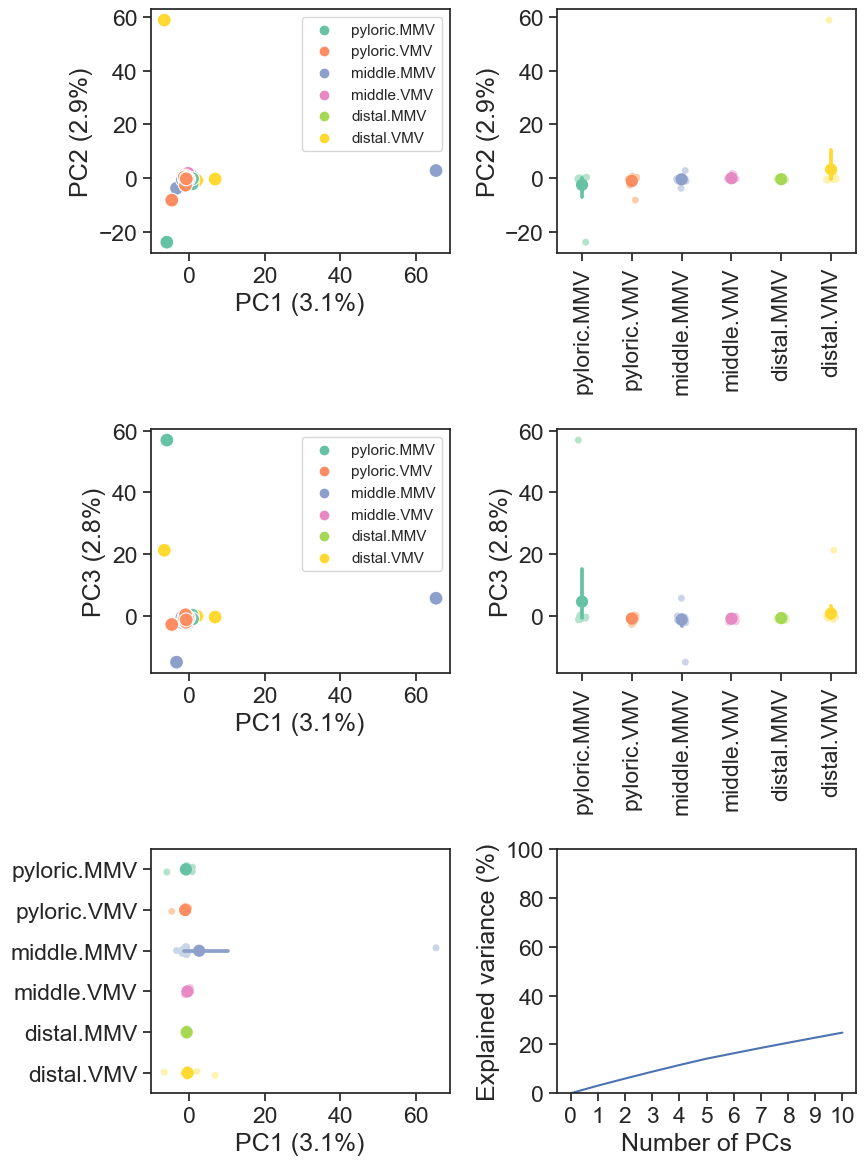

In [304]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[gut]
order = region_regime_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.region_regime, hue_order=order, palette=region_regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=11, loc='upper right').set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.region_regime, y=df.pc2, join=False, palette=region_regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.region_regime, y=df.pc2, palette=region_regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.region_regime, hue_order=order, palette=region_regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=11, loc='upper right').set_title(None)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.region_regime, y=df.pc3, join=False, palette=region_regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.region_regime, y=df.pc3, palette=region_regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.region_regime, x=df.pc1, join=False, palette=region_regime_palette, orient='h', order=order)
ax = sns.stripplot(y=df.region_regime, x=df.pc1, palette=region_regime_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x=x, y=y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_cnt_' + suffix + '.tiff'), bbox_inches='tight')

In [305]:
# Map samples to models (fast)

mapping = {}
matches = []
models = []

for i, row in tax_df.iterrows():
    if row.family == np.nan or row.family not in set(agora_tax_df.family):
        matches.append(np.nan)
        models.append(0)
        continue
    
    df = agora_tax_df[agora_tax_df.family == row.family]
    m = 'family'
    for rank in ('genus', 'species'):
        if row[rank] in set(df[rank]):
            df = df[df[rank] == row[rank]]
            m = rank
    
    mapping[row.name] = list(df.index)
    matches.append(m.capitalize())
    models.append(len(df))

tax_df['match'] = matches
tax_df['models'] = models
tax_df

,kingdom,phylum,class,order,family,genus,species,match,models
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN,Family,28
TGGGGAATCTTGCGCAATGGGCGAAAGCCTGACGCAGCAACGCCGCGTGCGGGATGAAGGCCTTCGGGTTGTAAACCGCTTTCAGCAGGGACGAAAATGACGGTACCTGCAGAAGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTCCGTAAGTCGAGTGTGAAAAATCTGGGCTCAACCCAGTGGAGCACTCGATACTGCGGTGACTAGAGTACGGTAGAGGAGTGTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCAACGGCGAAGGCAGCACTCTGGGCCGGTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACA,Bacteria,Actinobacteriota,Acidimicrobiia,Microtrichales,Microtrichaceae,NaN,NaN,NaN,0
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTAGGATCGTAAAACTCTGTTGTTGGAGAAGAACAGGGACTAGAGTAACTGTTAGTCCTTTGACGGTATCCAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATTAGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGTATGGGGAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,coryniformis,Species,1
TGGGGAATTTTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGATTTAGAAGGCCTTCGGGTTGTAAAAATCTTTTGTATAGGAAGAAAATGACAGTACTATACGAATAAGGTCCGGCTAATTACGTGCCAGCAGCCGCGGTAATACGTAAGGACCGAGCGTTGTCCGGAATCATTGGGCGTAAAGGGTACGTAGGCGGGTCATTAAGTTAGAAGTCAAAGGCTATAGCTCAACTATAGTAAGCTTCTAAAACTGGCGACCTTGAGTAATGGAAGGGAAAGTGGAATTCCTAGTGTAGCGGTGGAATGCGCAGATATTAGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCCATTAACTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Anaerococcus,NaN,NaN,NaN,0
TTGGGAATCTTGGACAATGGGGGAAACCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGAAGATAATGACTGTACCGGGAGAATAAGCTCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTTTCCAAGTCAGTGGTTAAAGCCCAGAGCTCAACTCTGGAATTGCCATTGAAACTGGTGAACTTGAGTACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTTACTGACGCTCAGGCGCGACAGCGTGGGGATCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Micropepsales,Micropepsaceae,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
TGGGGAATCTTGCGCAATGAGCGAAAGCGTGACGCAGCAACGCCGCGTGGGGGAAGACGGCCTTCGGGTTGTAAACCCCTTTCAGGAGGGACGAAGGTTCACCGGTGAATAGCCGTGTGGATTGACGGTACCTCCAGAAGAAGCTCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGAGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGCGTAGGAGGCCTCATAAGTCCGTTGTGAAAGTCAAAGGCTCAACCTTTGAAAGCCGATGGATACTGTGAGGCTAGAGTCCGGAAGAGGCGAGTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCAATAGCGAAGGCAGCTCGCTGGGACGGTACTGACGCTAAGGCGCGAAAGCGTGGGGAGCGAACA,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,NaN,NaN,0
TCGAGAATCTTTCGCAATGGGGGCAACCCTGACGAAGCGACGCCGCGTGGAGGATGAAGGCCTTTGGGTTGTAAACTCCTGTCGGCTGGGACGAAATAGTTGCTGATTAATAATCAGCAGCCTTGACGGTACCAGCAAAGGAAGCCACGGCTAACTCTGTGCCAGCAGCCGCGGTAATACAGAGGTGGCAAGCGTTGTTCGGATTTATTGGGCGTAAAGGGTCCGTAGGCGGTTCGGAAAGTCAGATGTGAAATCCTACAGCTCAACTGTAGAACTGCATTTGAAACTTCCGGACTAGAGTATGAGAGGGGTTAAGGGAATTCCCGGTGTAAGGGTGAAATCTGCAGAGATCGGGAGGAACACCAGTCGCGAAGGCGCTTAACTGGCTCATTACTGACGCTCAGGGACGAAAGCTAGGGGAGCAAACG,Bacteria,Verrucomicrobiota,Omnitrophia,Omnitrophales,Omnitrophaceae,Candidatus Omnitrophus,NaN,NaN,0
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCAATACCGCGTGTGTGAAGAAGGCCTTAGGGTTGTAAAGCACTTTCAATTGGGAGGAATACCTATCGGTTAATACCCGATAGATTGACATTACCTTTAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGTTATTTAAGTCAGATGTGAAAGCCCCGGGCTCAACTTGGGAACGGCATTTGATACTGAGTAACTCGAGTTTGGGAGATGTAAGTGGAATTTCAGGTGTAGCGGTGAAATGCGTAGATATCTGAAGGAACACCAGTGGCGAAGGCG

In [306]:
sns.set(font_scale=1.5, style='ticks')
df = tax_df
df = df.sort_values(by='match')
df

,kingdom,phylum,class,order,family,genus,species,match,models
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN,Family,28
TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGCAGGATGAAGGCCTTCGGGTTGTAAACTGCTTTTGTACGGAACGAAACGGCTCTTTCTAATAAAGAGGGCTAATGACGGTACCGTAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGACCTGCATTTGTGACTGCATAGCTGGAGTACGGTAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGACCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Comamonadaceae,Rhodoferax,NaN,Family,2
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCGACGCCGCGTGAGGGATGACGGCCTTCGGGTTGTAAACCTCTTTCAGTAGGGAAGAAGCGAAAGTGACGGTACCTGCAGAAGAAGCGCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGCGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGAGGCTCAACCTCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTTACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACA,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Micrococcaceae,Glutamicibacter,NaN,Family,7
TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTATGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGTTGTGAGGAAGGCGTTGAAGTTAATAGCTTCAGCGTTTGACGTTAGCAACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTCAACCTCGGAACAGCATTTTGAACTGGCAGACTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGATGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Photobacterium,piscicola,Family,9
TGGGGAATATTGCGCAATGGGGGAAACCCTGACGCAGCAACGCCGCGTGAATGAAGAAGGCCTTAGGGTTGTAAAGTTCTGTTTTCTGGGACGATAATGACGGTACCAGAGGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGATGCGTAGGCGGATGTTTAAGTGAGATGTGAAATACCCGGGCTCAACTTGGGTGCTGCATTTCAAACTGGATATCTAGAGTGCAGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGTAACTGACGCTGAGGCATGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium sensu stricto 13,NaN,Family,24
...,...,...,...,...,...,...,...,...,...
TGGGGAATATTGGGCAATGGGGGAAAACCTGACCCAGCAACGCCGCGTGAAGGAAGAAGGCCTTCGGGTTGTAAACTTCTTTTACCAGGGACGAACAAATGACGGTACCTGGAGAAAAAGCAACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTTGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGAGATGCAAGTTGGGAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTCAAAACTGCATCCCTTGAGTATCGGAGAGGCAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGACGACAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,UCG-005,NaN,NaN,0
TGGGGAATCTTGCGCAATGAGCGAAAGCGTGACGCAGCAACGCCGCGTGGGGGAAGACGGCCTTCGGGTTGTAAACCCCTTTCAGGAGGGACGAAGGTTCACCGGTGAATAGCCGTGTGGATTGACGGTACCTCCAGAAGAAGCTCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGAGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGCGTAGGAGGCCTCATAAGTCCGTTGTGAAAGTCAAAGGCTCAACCTTTGAAAGCCGATGGATACTGTGAGGCTAGAGTCCGGAAGAGGCGAGTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCAATAGCGAAGGCAGCTCGCTGGGACGGTACTGACGCTAAGGCGCGAAAGCGTGGGGAGCGAACA,Bacteria,Actinobacteriota,Thermoleophilia,Solirubrobacterales,67-14,NaN,NaN,NaN,0
TCGAGAATCTTTCGCAATGGGGGCAACCCTGACGAAGCGACGCCGCGTGGAGGATGAAGGCCTTTGGGTTGTAAACTCCTGTCGGCTGGGACGAAATAGTTGCTGATTAATAATCAGCAGCCTTGACGGTACCAGCAAAGGAAGCCACGGCTAACTCTGTGCCAGCAGCCGCGGTAATACAGAGGTGGCAAGCGTTGTTCGGATTTATTGGGCGTAAAGGGTCCGTAGGCGGTTCGGAAAGTCAGATGTGAAATCCTACAGCTCAACTGTAGAACTGCATTTGAAACTTCCGGACTAGAGTATGAGAGGGGTTAAGGGAATTCCCGGTGTAAGGGTGAAATCTGCAG

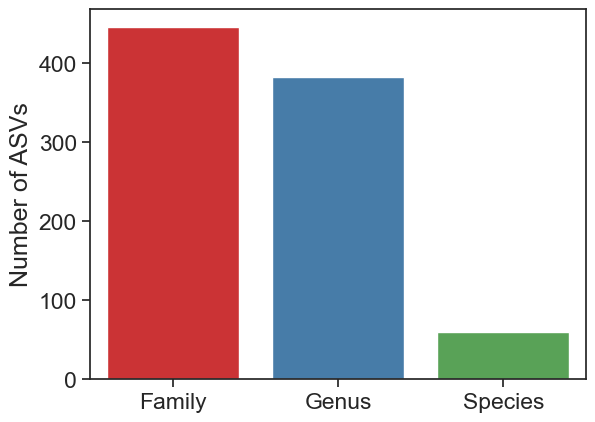

In [307]:
# Plot taxonomic level of match for each ASV
f = plt.figure()

counts = df['match'].value_counts()

ax = sns.barplot(x=counts.index, y=counts.values, palette='Set1')

plt.xlabel('Taxonomic level of model match')
plt.xlabel('')
plt.ylabel('Number of ASVs')

f.savefig(join(plot_dir, 'match_level_asv_' + suffix + '.tiff'), bbox_inches='tight')

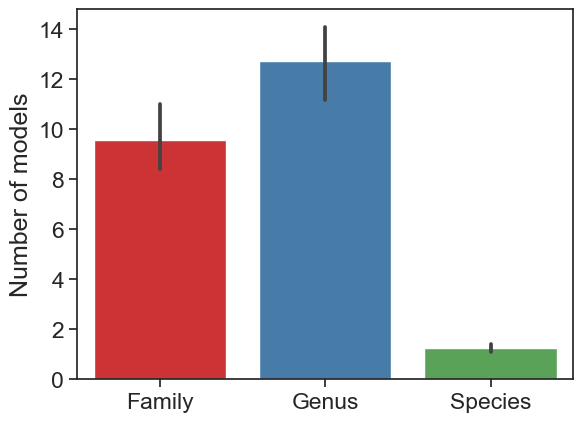

In [308]:
# Plot number of models mapped to each ASV by taxonomic level of match
f = plt.figure()

df = df[df.models > 0]
ax = sns.barplot(x=df.match, y=df.models, palette='Set1')

plt.xlabel('')
plt.ylabel('Number of models')

f.savefig(join(plot_dir, 'match_level_models_' + suffix + '.tiff'), bbox_inches='tight')

In [309]:
# Get fraction of models containing each reaction for each ASV
d = {}
for k, models in mapping.items():
    d[k] = rxn_df.iloc[:, models].mean(1)
asv_rxn_df = pd.DataFrame(d)
asv_rxn_df.to_csv(data_dir + '/asv_reactions_' + suffix + '.csv')
asv_rxn_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTAGGATCGTAAAACTCTGTTGTTGGAGAAGAACAGGGACTAGAGTAACTGTTAGTCCTTTGACGGTATCCAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATTAGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGTATGGGGAGCGAACA,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCAATGCCGCGTGTGTGAAGAAGGTCTTCGGATTGTAAAGCACTTTCGACGGGGACGATGATGACGGTACCCGTAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGTGTAGGCGGTTTGTACAGTCAGATGTGAAATCCCCGGGCTTAACCTGGGAGCTGCATTTGAGACGTGCAGACTAGAGTGTGAGAGAGGGTTGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCAACCTGGCTCATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTTGTACGGAACGAAAAAGCCTGCCCTAATACGGCGGGCTCATGACGGTACCGTAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTGATGTAAGACAGTTGTGAAATCCCCGGGCTCAACCTGGGAATTGCATCTGTGACTGCATCGCTAGAGTACGGTAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGACCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAAAGAAGAACAAGGATGAGAGTAACTGCTCATCCCCTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTCTTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGAGAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAACTCTGTTGTTAAAGAAGAACGTATCTGAGAGTAACTGTTCAGATAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCATTATCCGGATTTATTGGGCGTAAAGGGAGTGCAGGCGGTTATTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGGGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTACCTAGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAACA,TGAGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGACGGTCCTATGGATTGTAAACTGCTTTTGCACAGGAAGAAACACTCCCTCGTGAGGGAGCTTGACGGTACTGTGAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTTTAGTAAGTCAGTGGTGAAATCCCATCGCTCAACGGTGGAACGGCCATTGATACTGCTAGACTTGAATTATAAGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGAGATTACATGGAATACCAATTGCGAAGGCAGGTTACTACTTGTGGATTGACGCTGATGGACGAAAGCGTGGGTAGCGAACA,TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGAAGGTTTTCGGATCGTAAAACTCTGTTATTAGGGAAGAACAAATGTGTAAGTAACTGTGCACATCTTGACGGTACCTAATCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGAAACTTGAGTACAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCAAACA,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCCATGCCGCGTGTGTGAAGAAGGCCTTTTGGTTGTAAAGCACTTTAAGCAGTGAAGAAGACTCTAGGGTTAATACCCTTAGACGATGACATTAGCTGCAGAATAAGCACCGGCTAACTCTGTGCCAGCAGCCGCGGTAATACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGTAGGTGGCTTGATAAGTCAGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCTGATACTGTTAGGCTAGAGTAGGTGAGAGGAAGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCTTCTGGCATCATACTGACACTGAGGTTCGAAAGCGTGGGTAGCAAACA,TAGGGAATCTTCGGCAATGGACGAAAGTCTGACCGAGCAACGCCGCGTGAGTGAGGAAGGCCTTCGGGTCGTAAAGCTCTGTTGCCAGGGAAGAATGGCCGGGAGAGGGAATGCTCCTGGTTTGACGGTACCTGAGAAGAAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAA

In [310]:
# Calculate and save reaction abundances
rxn_cnt_df = cnt_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_frac_df = frac_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_cnt_df.T.to_csv(data_dir + '/reaction_counts_' + suffix + '.csv')
rxn_frac_df.T.to_csv(data_dir + '/reaction_frac_' + suffix + '.csv')

In [311]:
# Choose sample variables and palettes
c = ['region_regime', 'phase']
p = ['husl', 'Blues']

['distal.MMV', 'distal.VMV', 'middle.MMV', 'middle.VMV', 'pyloric.MMV', 'pyloric.VMV']
['challenge']


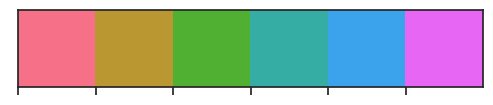

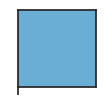

In [312]:
# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in rxn_frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

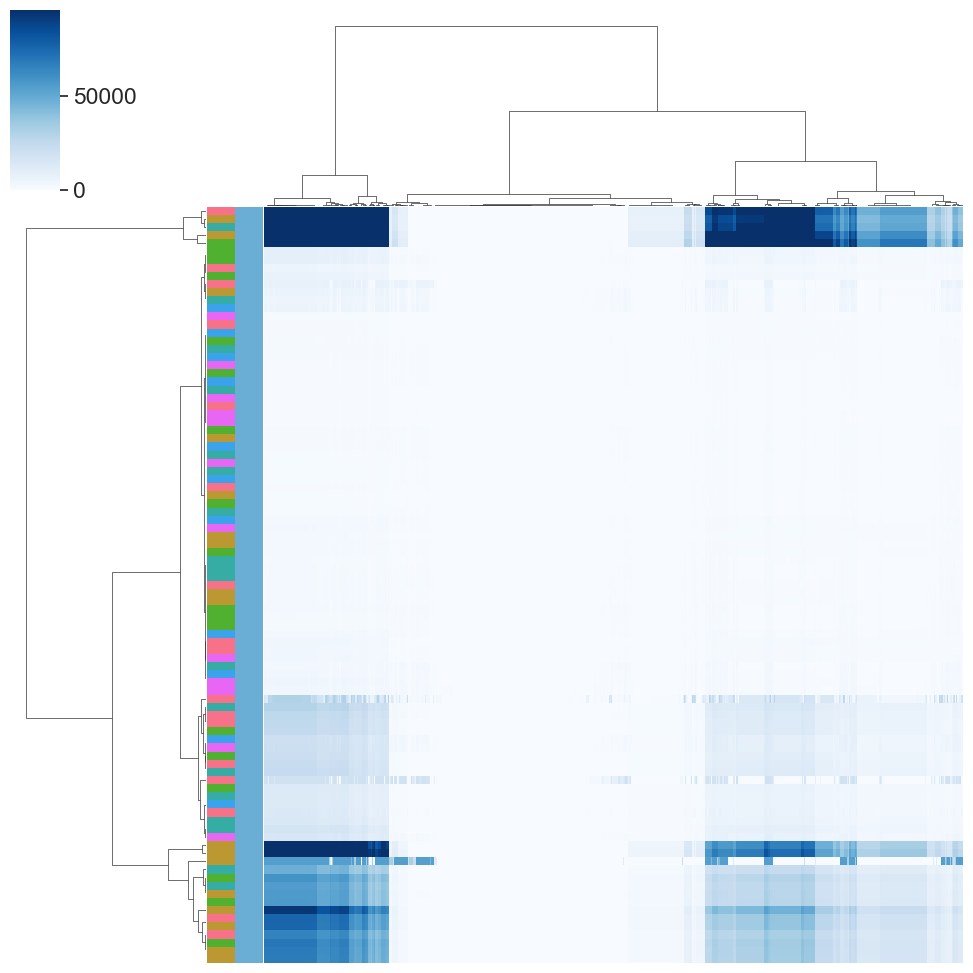

In [313]:
g = sns.clustermap(rxn_cnt_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, robust=True, row_colors=row_colors)
g.savefig(join(plot_dir, 'clustermap_rxn_cnt_' + suffix + '.png'), bbox_inches='tight')

In [314]:
# PCA on reaction abundances
pca = PCA()
Z = StandardScaler().fit_transform(rxn_frac_df[gut])
T = pca.fit_transform(Z)
T.shape

(93, 93)

In [315]:
n = 5
sample_df.loc[gut, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,sample.name,sample.no,sample_type,sample_region,phase,region,regime,region_regime,sample_regime,pc1,pc2,pc3,pc4,pc5
distal-MMV-T1-Rep1,3_1_1_D,187,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-48.300066,-5.490242,-2.532836,1.771459,0.013669
distal-MMV-T1-Rep2,3_1_2_D,180,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-56.365034,-3.641975,-2.632002,2.217565,0.862515
distal-MMV-T1-Rep3,3_1_3_D,246,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-55.829061,-3.711480,-2.740576,2.240907,0.836850
distal-MMV-T1-Rep4,3_1_4_D,146,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,31.016468,-9.492047,-4.637092,-5.441449,-0.538371
distal-MMV-T1-Rep5,3_1_5_D,99,gut,gut_distal,challenge,distal,MMV,distal.MMV,gut.MMV,-38.775015,8.482647,12.392006,-3.654586,1.928143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pyloric-VMV-T8-Rep1,3_8_1_P,222,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,-49.000559,-6.618158,-2.567624,0.998116,1.220144
pyloric-VMV-T8-Rep2,3_8_2_P,172,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,7.524087,9.555542,-15.917774,6.547152,-3.016146
pyloric-VMV-T8-Rep3,3_8_3_P,123,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,54.644529,8.535673,-14.990873,-8.590043,5.147965
pyloric-VMV-T8-Rep4,3_8_4_P,101,gut,gut_pyloric,challenge,pyloric,VMV,pyloric.VMV,gut.VMV,57.215880,-47.297513,3.360725,-64.489539,90.643648


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


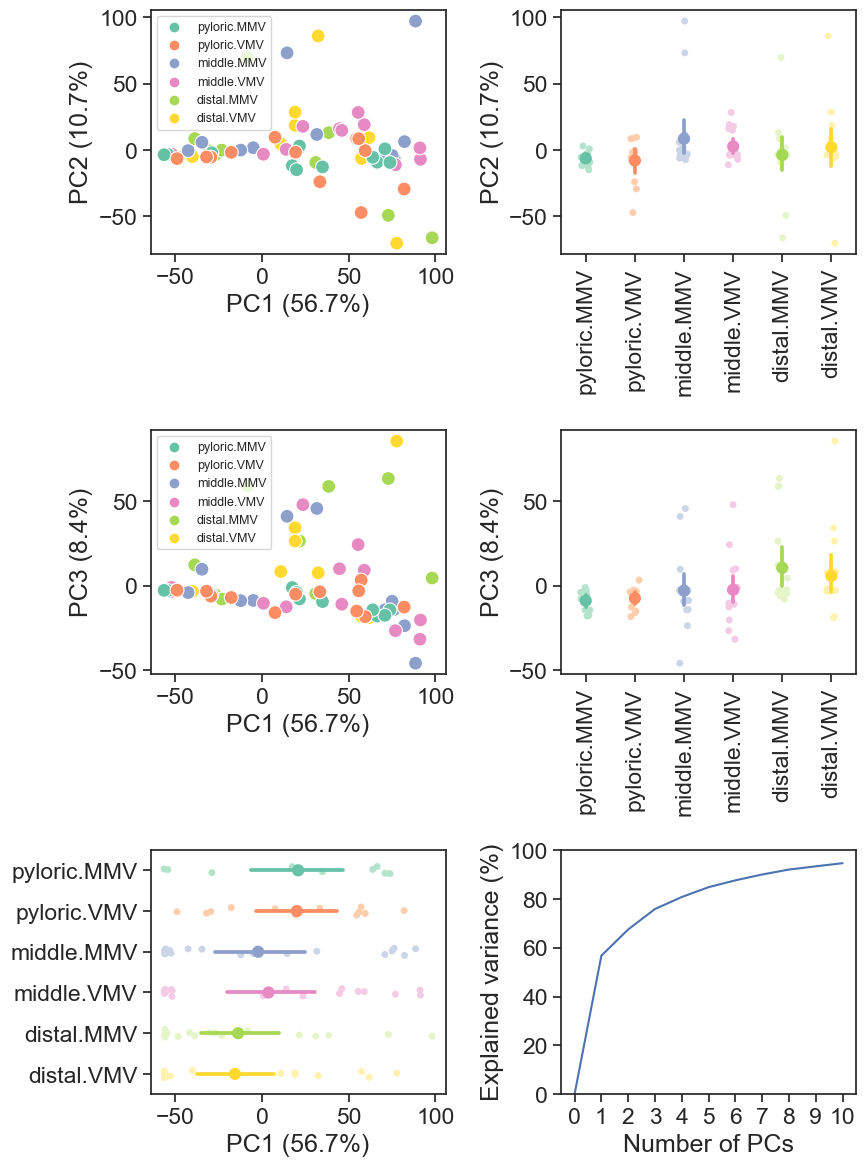

In [316]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[gut]
order = region_regime_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.region_regime, hue_order=order, palette=region_regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=9, loc='upper left').set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.region_regime, y=df.pc2, join=False, palette=region_regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.region_regime, y=df.pc2, palette=region_regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.region_regime, hue_order=order, palette=region_regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend(ncol=1, fontsize=9, loc='upper left').set_title(None)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.region_regime, y=df.pc3, join=False, palette=region_regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.region_regime, y=df.pc3, palette=region_regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.region_regime, x=df.pc1, join=False, palette=region_regime_palette, orient='h', order=order)
ax = sns.stripplot(y=df.region_regime, x=df.pc1, palette=region_regime_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x=x, y=y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_rxn_' + suffix + '.tiff'), bbox_inches='tight')

In [317]:
# Choose multiple testing correction method
method = 'fdr_bh'

In [318]:
# Pairwise comparison of region_regimes for each reaction

d = defaultdict(list)
df = sample_df[gut]

for x1, x2 in combinations(region_regime_order[suffix], 2):
    print(x1, x2)
    for r in rxn_frac_df.columns:
        if r.startswith('EX_') or r.startswith('sink_') or r.startswith('DM_') or r.startswith('biomass'):
            continue
        
        s = subsys[r]
        if not s or s.startswith('Transport') or s.startswith('Exchange') or s.startswith('Unassigned'):
            continue

        s1 = rxn_frac_df.loc[df[df.region_regime == x1].index, r]
        s2 = rxn_frac_df.loc[df[df.region_regime == x2].index, r]
        t, p = ttest_ind(s1, s2, equal_var=False)
        d['x1'].append(x1)
        d['x2'].append(x2)
        d['t'].append(t)
        d['p'].append(p)
        d['reaction'].append(r)
        d['subsys'].append(s)
        
rxn_comp_df = pd.DataFrame(d).dropna()

rxn_comp_df

pyloric.MMV pyloric.VMV
pyloric.MMV middle.MMV
pyloric.MMV middle.VMV
pyloric.MMV distal.MMV
pyloric.MMV distal.VMV
pyloric.VMV middle.MMV
pyloric.VMV middle.VMV
pyloric.VMV distal.MMV
pyloric.VMV distal.VMV
middle.MMV middle.VMV
middle.MMV distal.MMV
middle.MMV distal.VMV
middle.VMV distal.MMV
middle.VMV distal.VMV
distal.MMV distal.VMV


,x1,x2,t,p,reaction,subsys
0,pyloric.MMV,pyloric.VMV,0.450115,0.659147,23DHMPO,"Valine, leucine, and isoleucine metabolism"
1,pyloric.MMV,pyloric.VMV,0.011907,0.990615,26DAPLLAT,Lysine metabolism
2,pyloric.MMV,pyloric.VMV,0.450115,0.659147,2AHBUTI,"Valine, leucine, and isoleucine metabolism"
3,pyloric.MMV,pyloric.VMV,-0.305854,0.762905,2MBCOATA,Glycerophospholipid metabolism
4,pyloric.MMV,pyloric.VMV,-0.306481,0.762429,3HAD10M12,Fatty acid synthesis
...,...,...,...,...,...,...
52428,distal.MMV,distal.VMV,0.641608,0.526751,L2AADIPADOR,Lysine metabolism
52429,distal.MMV,distal.VMV,0.641608,0.526751,L2AADIPADOR2,Lysine metabolism
52430,distal.MMV,distal.VMV,0.641608,0.526751,r0594,Lysine metabolism
52431,distal.MMV,distal.VMV,1.000000,0.332195,SQLE,Cholesterol metabolism


In [322]:
# Correct for multiple testing and save
alpha = 0.05
rxn_comp_df['padj'] = multipletests(rxn_comp_df.p, method=method)[1]
rxn_comp_df.to_csv(data_dir + '/reaction_comp.csv')
(rxn_comp_df.padj < alpha).sum()

0

In [323]:
# Subsystem enrichment analysis (Fisher's exact test)

dd = defaultdict(list)

for x, df in rxn_comp_df.groupby(['x1', 'x2']):
    for s in sorted(set(df.subsys)):
        a = ((df.subsys == s) & (df.padj <= alpha)).sum()
        b = ((df.subsys != s) & (df.padj <= alpha)).sum()
        c = ((df.subsys == s) & (df.padj > alpha)).sum()
        d = ((df.subsys != s) & (df.padj > alpha)).sum()
        n = a + b + c + d
        
        r, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        
        dd['x1'].append(x[0])
        dd['x2'].append(x[1])
        dd['subsys'].append(s)
        dd['a'].append(a)
        dd['b'].append(b)
        dd['c'].append(c)
        dd['d'].append(d)
        dd['n'].append(n)
        dd['r'].append(r)
        dd['p'].append(p)
        
        if p <= alpha:
            print(x, s, p)
            print(a, b, c, d)
        
subsys_comp_df = pd.DataFrame(dd)

subsys_comp_df

,x1,x2,subsys,a,b,c,d,n,r,p
0,distal.MMV,distal.VMV,Alanine and aspartate metabolism,0,0,19,3399,3418,NaN,1.0
1,distal.MMV,distal.VMV,Alkaloid synthesis,0,0,1,3417,3418,NaN,1.0
2,distal.MMV,distal.VMV,Aminobenzoate degradation,0,0,3,3415,3418,NaN,1.0
3,distal.MMV,distal.VMV,Aminophosphonate metabolism,0,0,1,3417,3418,NaN,1.0
4,distal.MMV,distal.VMV,Aminosugar metabolism,0,0,27,3391,3418,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
1429,pyloric.VMV,middle.VMV,Vitamin B6 metabolism,0,0,17,3434,3451,NaN,1.0
1430,pyloric.VMV,middle.VMV,Vitamin C metabolism,0,0,1,3450,3451,NaN,1.0
1431,pyloric.VMV,middle.VMV,Wood-Ljungdahl Pathway,0,0,6,3445,3451,NaN,1.0
1432,pyloric.VMV,middle.VMV,beta-Alanine metabolism,0,0,8,3443,3451,NaN,1.0


In [324]:
# Correct for multiple testing and save
alpha = 0.05
subsys_comp_df['padj'] = multipletests(subsys_comp_df.p, method=method)[1]
subsys_comp_df.to_csv(data_dir + '/subsys_comp.csv')
(subsys_comp_df.padj < alpha).sum()

0

In [325]:
# Plot t-statistic for each reaction, significant subsystem, and region_regime pair
import random
random.seed(12345) # set seed
sns.set(style='ticks', font_scale=1.5)

alpha = 0.05

for x, df in rxn_comp_df.dropna().groupby(['x1', 'x2']): 
#     df = df[(df.subsys != '') & (df.padj < alpha)]
    df = df[(df.subsys != '')]
    
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x[0]) & (ss_df.x2 == x[1]) & (ss_df.padj <= alpha)]
    ss = set(ss_df.subsys)
    
    df = df[df.subsys.isin(ss)]
    
    if df.empty:
        continue
    
    f = plt.figure()
    
    xmax = df.t.abs().max()
    xmax = np.ceil(df.t.abs().max() / 5) * 5
    xlim = -xmax, xmax
    ylim = df.subsys.nunique() - 0.5, -0.5
        
#     s = df[df.t < 0].subsys.value_counts().sort_values(ascending=False)
#     ax = plt.barh(y=s.index, width=-s.values)

#     s = df[df.t > 0].subsys.value_counts().sort_values(ascending=False)
#     plt.barh(y=s.index, width=s.values)
    t_mean = df.groupby('subsys').t.mean()
    order = list(t_mean.sort_values(ascending=True).index)
    hue = [dict(t_mean > 0)[x] for x in df.subsys] 
    
    p1 = sns.color_palette('Pastel1', 2)
    p2 = sns.color_palette('Set1', 2)
    if df.t.max() < 0:
        p1.pop()
    elif df.t.min() > 0:
        p1.pop(0)
    if t_mean.max() < 0:
        p2.pop()
    elif t_mean.min() > 0:
        p2.pop(0)
        
#     hue = df.t < 0
#     hue = df.t != 0
    
#     ss_df['recall'] = ss_df.a / ss_df[['a', 'c']].sum(1)
#     ss_df = ss_df.sort_values(by='recall', ascending=True)
#     order = ss_df.subsys
    order = ss_df.sort_values(by='padj', ascending=True).subsys

#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], hue=hue, palette='Set1', color='#b3cde3', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj > alpha], color='#f2f2f2', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, palette=['#999999', '#e41a1c'], size=2, order=order)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], color='#e41a1c', size=5, order=order)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, order=order, palette=['#d9d9d9', '#e41a1c'], size=2)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8')
    ax = sns.stripplot(x=df.t, y=df.subsys, hue=df.t > 0, palette=p1, jitter=0.1, order=order, size=4, zorder=2, linewidth=0.5)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8', ci=95, zorder=2)
    ax = sns.barplot(x=df.t, y=df.subsys, hue=hue, palette=p2, order=order, dodge=False, ci=95, zorder=1)
    
    plt.plot([0, 0], ylim, c='k', ls='--')
    
    plt.arrow(-0.05 * xmax, -1, -0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.arrow(0.05 * xmax, -1, 0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.text(-xmax / 2, -1.5, 'Higher in {}'.format(x[1]), ha='center')
    plt.text(xmax / 2, -1.5, 'Higher in {}'.format(x[0]), ha='center')

#     plt.title(' vs. '.join(x))
    plt.xlabel('Subsystem difference')
    plt.xlabel('$t$-statistic')
    plt.ylabel('')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True, ls='--')
    ax.legend().set_visible(False)
    
#     plt.subplot(1, 6, 4)
#     ax = plt.barh(y=ss_df.subsys, width=ss_df.recall, tick_label='')
    
    f.set_size_inches(5, len(set(df.subsys)) / 2)
    f.savefig(join(plot_dir, '_'.join(x).lower() + '_subsys_diff_' + suffix + '.tiff'), bbox_inches='tight')
#     break

In [326]:
# Compute mean t-statistic for each significant subsystem
d = defaultdict(dict)
alpha = 0.05
order = region_regime_order[suffix]
for (x1, x2), df in rxn_comp_df.groupby(['x1', 'x2']):
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x1) & (ss_df.x2 == x2) & (ss_df.padj <= alpha)]
    df = df[df.subsys.isin(set(ss_df.subsys))]
    if df.empty:
        continue
    for ss in df.subsys:
        d[(x1, x2)][ss] = df[df.subsys == ss].t.mean()
        d[(x2, x1)][ss] = -df[df.subsys == ss].t.mean()
df = pd.DataFrame(d).fillna(0)
df = df.loc[df.any(1)]
df = df[list(permutations(order, 2))]
df

KeyError: "None of [Index([('pyloric.MMV', 'pyloric.VMV'),  ('pyloric.MMV', 'middle.MMV'),\n        ('pyloric.MMV', 'middle.VMV'),  ('pyloric.MMV', 'distal.MMV'),\n        ('pyloric.MMV', 'distal.VMV'), ('pyloric.VMV', 'pyloric.MMV'),\n        ('pyloric.VMV', 'middle.MMV'),  ('pyloric.VMV', 'middle.VMV'),\n        ('pyloric.VMV', 'distal.MMV'),  ('pyloric.VMV', 'distal.VMV'),\n        ('middle.MMV', 'pyloric.MMV'),  ('middle.MMV', 'pyloric.VMV'),\n         ('middle.MMV', 'middle.VMV'),   ('middle.MMV', 'distal.MMV'),\n         ('middle.MMV', 'distal.VMV'),  ('middle.VMV', 'pyloric.MMV'),\n        ('middle.VMV', 'pyloric.VMV'),   ('middle.VMV', 'middle.MMV'),\n         ('middle.VMV', 'distal.MMV'),   ('middle.VMV', 'distal.VMV'),\n        ('distal.MMV', 'pyloric.MMV'),  ('distal.MMV', 'pyloric.VMV'),\n         ('distal.MMV', 'middle.MMV'),   ('distal.MMV', 'middle.VMV'),\n         ('distal.MMV', 'distal.VMV'),  ('distal.VMV', 'pyloric.MMV'),\n        ('distal.VMV', 'pyloric.VMV'),   ('distal.VMV', 'middle.MMV'),\n         ('distal.VMV', 'middle.VMV'),   ('distal.VMV', 'distal.MMV')],\n      dtype='object')] are in the [columns]"

ValueError: negative dimensions are not allowed

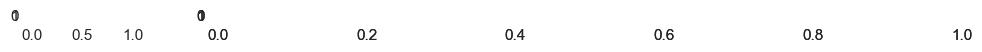

In [327]:
# Clustered heatmap of mean t-statistics (customized for data from Pabo)
if suffix == 'marwa':
    sns.set(font_scale=1)

    region_regimes = region_regime_order[suffix]

    p = dict(zip(region_regimes, region_regime_palette))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.85, 0.09, 0.02, 0.1)
    figsize=(12, len(df) / 3)
    dendrogram_ratio=0.12
    colors_ratio=0.025

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(region_regimes) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, region_regime in enumerate(region_regimes):
        g.ax_heatmap.text(2.5 + i * 5, -2.1, region_regime, ha='center', fontsize=fontsize * 1.5, color=p[region_regime], weight='bold')
    g.ax_heatmap.text(-2.5, -1.2, 'region_regime 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'region_regime 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(5, 5, 'Higher in\nregion_regime 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(5, -5, 'Higher in\nregion_regime 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.tiff'), bbox_inches='tight')

ValueError: negative dimensions are not allowed

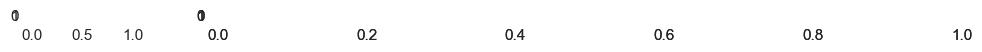

In [328]:
# Clustered heatmap of mean t-statistics (customized for data from Jeleel)
if suffix == 'marwa':
  sns.set(font_scale=1)

region_regimes = region_regime_order[suffix]

p = dict(zip(region_regimes, region_regime_palette))
col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

cbar_pos = (0.8, 0.72, 0.02, 0.175)
figsize=(12, len(df) / 2.5)
dendrogram_ratio=0.12
colors_ratio=0.08

g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
for i in range(len(region_regimes) - 1):
  g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

fontsize = 14
g.ax_heatmap.set_xlabel('')
#     g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
for i, region_regime in enumerate(region_regimes):
  g.ax_heatmap.text(2.5 + i * 5, -2.5, region_regime, ha='center', fontsize=fontsize * 1.5, color=p[region_regime], weight='bold')
g.ax_heatmap.text(-2.5, -1.4, 'region_regime 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
g.ax_heatmap.text(-2.5, -0.2, 'region_regime 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
g.ax_cbar.text(250, 12, 'Higher in region_regime 1', ha='center', va='center', color='#053061', fontsize=fontsize)
g.ax_cbar.text(250, -12, 'Higher in region_regime 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.tiff'), bbox_inches='tight')